<a href="https://colab.research.google.com/github/hanshanaweerakoon/Machine-Learning-Based-Optimization-of-Error-Correcting-Codes/blob/main/NBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import pyldpc


# ===============================================================
# 1. Code Definition
# ===============================================================
# Define the parameters for an LDPC code
n = 24     # Codeword length
d_v = 2     # Number of 1s per column in H
d_c = 4     # Number of 1s per row in H
H, G = pyldpc.make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
H = torch.tensor(H, dtype=torch.float32)

print(f"Generated H matrix of shape: {H.shape}")

# ===============================================================
# 2. Neural BP Layer Implementation 🧠
# ===============================================================
class NeuralBP(nn.Module):
    """
    Implements a learnable Belief Propagation decoder.
    The weights on the messages are treated as trainable parameters.
    """
    def __init__(self, H, num_iter=3):
        super().__init__()
        self.H = H
        self.num_iter = num_iter

        # Trainable weights for each edge at each iteration
        self.weights = nn.Parameter(torch.ones(num_iter, *H.shape))

        # Precompute neighbor indices for efficiency
        self.check_neighbors = [torch.where(H[i, :] == 1)[0] for i in range(H.shape[0])]
        self.var_neighbors   = [torch.where(H[:, j] == 1)[0] for j in range(H.shape[1])]

    def forward(self, llr_channel):
        """
        Executes the neural BP decoding process.
        """
        m, n = self.H.shape
        # Messages from variable nodes to check nodes
        Lq = torch.zeros(m, n, device=llr_channel.device)
        # Messages from check nodes to variable nodes
        Lr = torch.zeros(m, n, device=llr_channel.device)

        # The decoder is unrolled for a fixed number of iterations
        for t in range(self.num_iter):
            # --- Check node update (using Min-Sum approximation) ---
            for i in range(m):
                idx = self.check_neighbors[i]
                if len(idx) == 0: continue

                # Gather incoming messages for this check node
                incoming_msgs = Lq[i, idx]

                # For each connected variable node, compute the outgoing message
                for j_node_idx, j in enumerate(idx):
                    # Extrinsic principle: use all messages except the one from the target node
                    others = torch.cat([incoming_msgs[:j_node_idx], incoming_msgs[j_node_idx+1:]])

                    if len(others) == 0: continue

                    # Min-Sum update rule
                    signs = torch.prod(torch.sign(others))
                    abs_min = torch.min(torch.abs(others))
                    msg = signs * abs_min

                    # Apply the learned weight for this edge and iteration
                    Lr[i, j] = self.weights[t, i, j] * msg

            # --- Variable node update ---
            for j in range(n):
                idx = self.var_neighbors[j]
                if len(idx) == 0: continue

                # Sum of incoming messages from check nodes
                sum_lr = torch.sum(Lr[idx, j], dim=0)

                # Extrinsic principle: add channel LLR and subtract the message being sent back
                Lq[idx, j] = llr_channel[j] + sum_lr - Lr[idx, j]

        # --- Final posterior LLR calculation ---
        final_Lr_sum = torch.sum(Lr, dim=0)
        L_posterior = llr_channel + final_Lr_sum

        # Return probabilities (for BCELoss)
        return torch.sigmoid(-L_posterior)

# ===============================================================
# 3. Training Setup and Simulation
# ===============================================================
# Channel simulation function
def awgn_channel(x, snr_db):
    """Simulates passing BPSK symbols through an AWGN channel."""
    snr_linear = 10 ** (snr_db / 10.0)
    # Rate is k/n, k = rank of G
    k = np.linalg.matrix_rank(G)
    rate = k / x.shape[-1]
    sigma = np.sqrt(1 / (2 * rate * snr_linear))
    noise = sigma * np.random.randn(*x.shape)
    return x + noise

# --- Hyperparameters ---
DEVICE = torch.device('cpu')
model = NeuralBP(H, num_iter=5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
NUM_EPOCHS = 10
BATCHES_PER_EPOCH = 50
SNR_DB = 2.5 # Training SNR

# --- Training Loop ---
print(f"\nStarting training on {DEVICE} for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for _ in tqdm(range(BATCHES_PER_EPOCH), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):

        # 1. Generate a random message and encode it
        msg = np.random.randint(0, 2, G.shape[1])
        codeword = pyldpc.encode(G, msg,1000)

        # 2. BPSK modulation (0 -> +1, 1 -> -1)
        #transmitted_signal = 1 - 2 * codeword

        # 3. Pass through AWGN channel
        received_signal = awgn_channel(transmitted_signal, SNR_DB)
        for i in range(len(codeword)):
            if codeword[i] < 0:
                codeword[i] = 1
            else:
                codeword[i] = 0
        # 4. Calculate initial LLRs from the channel
        # For BPSK over AWGN, LLR(y) = 2*y/sigma^2. Since sigma^2 is constant for a given SNR,
        # we can use a simplified LLR proportional to y.
        llr_initial = 2 * torch.tensor(received_signal, dtype=torch.float32).to(DEVICE)

        # 5. Get model prediction and compute loss
        target = torch.tensor(codeword, dtype=torch.float32).to(DEVICE)
        prediction = model(llr_initial)

        loss = loss_fn(prediction, target)

        # 6. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / BATCHES_PER_EPOCH
    print(f"Epoch {epoch+1} complete | Average Loss = {avg_loss:.5f}")

print("\nTraining finished!")

# Optional: Print a sample of the learned weights from the first iteration
print("\nSample of learned weights (first iteration, non-one values):")
trained_weights = model.weights.data[0].cpu().numpy()
non_one_weights = trained_weights[trained_weights != 1.0]
print(non_one_weights[:15])

Generated H matrix of shape: torch.Size([12, 24])

Starting training on cpu for 10 epochs...


Epoch 1/10: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Epoch 1 complete | Average Loss = 3.61490


Epoch 2/10: 100%|██████████| 50/50 [00:04<00:00, 11.12it/s]


Epoch 2 complete | Average Loss = 3.34375


Epoch 3/10: 100%|██████████| 50/50 [00:04<00:00, 11.60it/s]


Epoch 3 complete | Average Loss = 3.53785


Epoch 4/10: 100%|██████████| 50/50 [00:05<00:00,  9.64it/s]


Epoch 4 complete | Average Loss = 3.35863


Epoch 5/10: 100%|██████████| 50/50 [00:04<00:00, 11.61it/s]


Epoch 5 complete | Average Loss = 3.17972


Epoch 6/10: 100%|██████████| 50/50 [00:04<00:00, 10.18it/s]


Epoch 6 complete | Average Loss = 2.87865


Epoch 7/10: 100%|██████████| 50/50 [00:04<00:00, 12.23it/s]


Epoch 7 complete | Average Loss = 3.18131


Epoch 8/10: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]


Epoch 8 complete | Average Loss = 2.81627


Epoch 9/10: 100%|██████████| 50/50 [00:04<00:00, 10.01it/s]


Epoch 9 complete | Average Loss = 2.82289


Epoch 10/10: 100%|██████████| 50/50 [00:04<00:00, 10.99it/s]

Epoch 10 complete | Average Loss = 2.54161

Training finished!

Sample of learned weights (first iteration, non-one values):
[]


Starting training on device: cpu
Epoch 5/60 | Loss = 129.336884
Epoch 10/60 | Loss = 136.985458
Epoch 15/60 | Loss = 118.858131
Epoch 20/60 | Loss = 124.830116
Epoch 25/60 | Loss = 116.456909
Epoch 30/60 | Loss = 122.804787
Epoch 35/60 | Loss = 117.894615
Epoch 40/60 | Loss = 119.607025
Epoch 45/60 | Loss = 114.300575
Epoch 50/60 | Loss = 115.301636
Epoch 55/60 | Loss = 110.670418
Epoch 60/60 | Loss = 105.916832
SNR -2 dB -> BER 9.04990e-01
SNR -1 dB -> BER 9.57812e-01
SNR 0 dB -> BER 9.85635e-01
SNR 1 dB -> BER 9.98156e-01
SNR 2 dB -> BER 9.99719e-01
SNR 3 dB -> BER 9.99990e-01
SNR 4 dB -> BER 1.00000e+00
SNR 5 dB -> BER 1.00000e+00


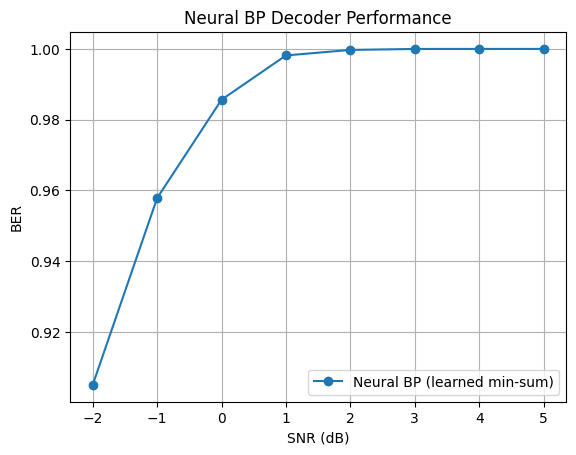

In [ ]:
# neural_bp_full.py
# ==========================================================
# Full Neural Belief Propagation (vectorized, exact min-exclusion)
# Requirements: pip install torch pyldpc numpy matplotlib tqdm
# ==========================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pyldpc
import matplotlib.pyplot as plt
from tqdm import trange

# ------------------------
# 1) LDPC code parameters
# ------------------------
n, d_v, d_c = 96, 3, 6  # you can change these
H_np, G = pyldpc.make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
# Convert H to float32 tensor (0/1)
H_torch = torch.tensor(H_np.astype(np.float32), dtype=torch.float32)

# ------------------------
# 2) Data generation
# ------------------------
def generate_batch(batch_size, snr_db):
    """
    Returns:
      llr: torch.float32 tensor (batch_size, n) -- channel LLRs for codeword bits
      code_bits: torch.float32 tensor (batch_size, n) -- target bits {0,1}
    """
    # random messages (batch, k)
    k = G.shape[1]
    msg = np.random.randint(0, 2, size=(batch_size, k))
    # Encode to codeword symbols (pyldpc.encode often returns +1/-1 BPSK symbols)
    code_symbols_list = []
    for m in msg:
        # Use snr=1000 to get noiseless codeword symbols
        cw = pyldpc.encode(G, m, snr=1000)
        code_symbols_list.append(cw)
    code_symbols = np.stack(code_symbols_list)  # shape (batch, n)

    # Detect mapping: if code_symbols are in {0,1} convert -> BPSK 1 - 2*bit
    unique_min = code_symbols.min()
    unique_max = code_symbols.max()
    if unique_min >= 0 and unique_max <= 1:
        # bits 0/1 -> BPSK
        bpsk = 1.0 - 2.0 * code_symbols
    else:
        # assume already +1/-1
        bpsk = code_symbols.astype(np.float32)

    # target bits (0/1): code_bit = 1 if symbol is -1 (BPSK mapping)
    code_bits = (bpsk < 0).astype(np.float32)

    # AWGN noise
    snr_lin = 10 ** (snr_db / 10.0)
    # Calculate noise variance based on energy per bit (Eb) to noise power spectral density (N0) ratio
    # For BPSK, Eb = 1. Assuming codeword symbols are +/-1.
    # Eb/N0 = snr_lin
    # N0 = Eb / snr_lin = 1 / snr_lin
    # sigma^2 = N0 / 2 = 1 / (2 * snr_lin)
    sigma2 = 1.0 / (2.0 * snr_lin)
    noise = np.sqrt(sigma2) * np.random.randn(*bpsk.shape)
    y = bpsk + noise # Apply noise to BPSK symbols

    # Channel LLRs for BPSK (assuming equal priors):
    # LLR = 2 * y / sigma^2
    llr = 2.0 * y / sigma2  # shape (batch, n)

    return torch.tensor(llr, dtype=torch.float32), torch.tensor(code_bits, dtype=torch.float32)

# ------------------------
# 3) NeuralBP model
# ------------------------
class NeuralBP(nn.Module):
    def __init__(self, H, n_iters=5):
        """
        H: (m, n) parity-check matrix tensor with 0/1 entries
        """
        super().__init__()
        assert H.dim() == 2
        self.register_buffer('H_mask', H)   # (m, n)
        m, n = H.shape
        self.m = m
        self.n = n
        self.n_iters = n_iters

        # Learnable weights per edge per iteration, masked by H.
        # We'll store them as a ParameterList of (m,n) tensors that get multiplied by H_mask.
        self.weights = nn.ParameterList([
            nn.Parameter(torch.ones(m, n) * H) for _ in range(n_iters)
        ])
    def forward(self, llr):
        """
        llr: (batch, n) channel LLRs
        returns:
          Lpost: (batch, n) posterior LLRs (logits) for each code bit
        """
        device = llr.device
        H = self.H_mask.to(device)                      # (m, n)
        batch = llr.shape[0]

        # Initialize variable->check messages Lq (batch, m, n)
        # Put llr on each incident edge; zero out non-edges
        # Lq_v_to_c = llr_v + sum_{c' in N(v)\c} Lr_{c' to v}
        # Lq is initialized with channel LLRs
        Lq = llr.unsqueeze(1).repeat(1, self.m, 1) * H.unsqueeze(0)  # (batch, m, n)
        Lr = torch.zeros_like(Lq)  # check->variable messages

        large = 1e6  # large value for masking

        for t in range(self.n_iters):
            W = (self.weights[t] * H).to(device)  # (m, n); masked weights

            # --------------------
            # Check node update (min-sum exact excluding edge)
            # --------------------
            # sign of Lq; non-edge positions -> +1 (so they don't affect prod)
            sign = torch.sign(Lq)
            sign = torch.where(H.unsqueeze(0) > 0, sign, torch.ones_like(sign))

            # product of signs across all variable neighbors for each check: (batch, m, 1)
            prod_all = torch.prod(sign, dim=2, keepdim=True)  # (batch, m, 1)

            # sign excluding current edge = prod_all / sign_edge
            # avoid dividing by zero by adding tiny eps
            eps = 1e-12
            sign_excl = prod_all / (sign + eps)  # (batch, m, n)

            # magnitudes absolute
            abs_Lq = torch.abs(Lq)  # (batch, m, n)
            # mask non-edges with large so they are ignored in mins
            abs_masked = torch.where(H.unsqueeze(0) > 0, abs_Lq, torch.full_like(abs_Lq, large))

            # =========================================================================
            # EFFICIENT REPLACEMENT for finding first and second minimums
            # This avoids creating multiple large intermediate tensors and should fix the memory crash.
            # =========================================================================
            # Find the top 2 smallest values and their indices along the last dimension
            top2_vals, top2_indices = torch.topk(abs_masked, 2, dim=2, largest=False)

            # Separate them into first and second minimums
            first_min_vals = top2_vals[:, :, 0:1]   # Shape: (batch, m, 1)
            second_min_vals = top2_vals[:, :, 1:2]  # Shape: (batch, m, 1)
            argmin_idx = top2_indices[:, :, 0:1]    # Shape: (batch, m, 1)

            # Create a boolean mask indicating the position of the first minimum
            arange = torch.arange(self.n, device=device).view(1, 1, self.n)
            is_argmin = (arange == argmin_idx)

            # For each edge, if it's the minimum, use the second minimum's value, otherwise use the first.
            min_excl = torch.where(is_argmin, second_min_vals, first_min_vals)
            # =========================================================================

            # Build final check->variable message (min-sum) with learned weight:
            # Lr = W * sign_excl * min_excl, but zero at non-edges
            Lr = (W.unsqueeze(0) * sign_excl * min_excl) * H.unsqueeze(0)

            # --------------------
            # Variable node update
            # --------------------
            # For each variable node, new Lq for each incident edge:
            # Lq = llr + sum_all_Lr - Lr  (sum over check neighbors)
            # sum_all_Lr is the sum of incoming messages from all connected check nodes
            sum_Lr = torch.sum(Lr, dim=1, keepdim=True)  # (batch, 1, n)
            # Lq_v_to_c = llr_channel_v + sum_{c' in N(v)\c} Lr_{c' to v}
            # The current Lq_{v to c} is llr_channel_v + sum_{c'' in N(v)\c} Lr_{c'' to v} from previous iteration.
            # The new Lq should be llr_channel_v + sum_{c' in N(v)\c} Lr_{c' to v} where Lr is from the current iteration.
            # So, Lq_new = llr_channel + (sum_all_Lr - Lr_current_iteration)
            Lq = llr.unsqueeze(1) + sum_Lr - Lr           # (batch, m, n)
            # zero non-edges (safety)
            Lq = Lq * H.unsqueeze(0)


        # Posterior LLRs per variable node (code bit): llr + sum over checks of last Lr
        Lpost = llr + torch.sum(Lr, dim=1)  # (batch, n)
        return Lpost






# ------------------------
# 4) Training loop
# ------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralBP(H_torch,n_iters=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # expects logits and targets in {0,1}

# Training hyperparams
snr_db_train = 2.0
epochs = 60
batch_size = 128

print("Starting training on device:", device)
for epoch in range(epochs):
    model.train()
    llr_batch, code_bits_batch = generate_batch(batch_size, snr_db_train)
    llr_batch = llr_batch.to(device)
    code_bits_batch = code_bits_batch.to(device)

    optimizer.zero_grad()
    out = model(llr_batch)                 # (batch, n) logits (posterior LLR)
    loss = criterion(out, code_bits_batch) # BCEWithLogitsLoss
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss = {loss.item():.6f}")

# ------------------------
# 5) BER test
# ------------------------
def test_ber(model, snr_db, N=200):
    model.eval()
    with torch.no_grad():
        llr_batch, code_bits = generate_batch(N, snr_db)
        llr_batch = llr_batch.to(device)
        out = model(llr_batch)  # (N, n)
        # Apply sigmoid to convert logits to probabilities and then threshold at 0.5
        decoded_bits = (torch.sigmoid(out) > 0.5).int().cpu()
        # Calculate BER by comparing decoded bits to original code bits
        ber = (decoded_bits != code_bits.int()).float().mean().item()
    return ber

snr_range = np.arange(-2, 6, 1)  # from -2 dB to 5 dB
ber_nb = []
for snr in snr_range:
    # Increased N for better BER estimation at lower BERs
    b = test_ber(model, snr_db=snr, N=1000)
    ber_nb.append(b)
    print(f"SNR {snr} dB -> BER {b:.5e}")
plt.plot(snr_range, ber_nb, 'o-', label='Neural BP (learned min-sum)')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Neural BP Decoder Performance')
plt.grid(True, which='both')
plt.legend()
plt.show()